In [19]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper


In [20]:
import jax
import jax.numpy as jnp
import chex
import numpy as np
from flax import struct
from functools import partial
from typing import Optional, Tuple, Union, Any
from gymnax.environments import environment, spaces
from gymnax.wrappers.purerl import GymnaxWrapper
from brax import envs
from brax.envs.wrappers.training import EpisodeWrapper, AutoResetWrapper
# from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper

class BraxGymnaxWrapper:
    def __init__(self, env_name, backend="positional"):
        env = envs.get_environment(env_name=env_name, backend=backend)
        env = EpisodeWrapper(env, episode_length=1000, action_repeat=1)
        env = AutoResetWrapper(env)
        self._env = env
        self.action_size = env.action_size
        self.observation_size = (env.observation_size,)

    def reset(self, key, params=None):
        state = self._env.reset(key)
        return state.obs, state

    def step(self, key, state, action, params=None):
        next_state = self._env.step(state, action)
        return next_state.obs, next_state, next_state.reward, next_state.done > 0.5, {}

    def observation_space(self, params):
        return spaces.Box(
            low=-jnp.inf,
            high=jnp.inf,
            shape=(self._env.observation_size,),
        )

    def action_space(self, params):
        return spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(self._env.action_size,),
        )

class ClipAction(GymnaxWrapper):
    def __init__(self, env, low=-1.0, high=1.0):
        super().__init__(env)
        self.low = low
        self.high = high

    def step(self, key, state, action, params=None):
        """TODO: In theory the below line should be the way to do this."""
        # action = jnp.clip(action, self.env.action_space.low, self.env.action_space.high)
        action = jnp.clip(action, self.low, self.high)
        return self._env.step(key, state, action, params)

class VecEnv(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.reset = jax.vmap(self._env.reset, in_axes=(0, None))
        self.step = jax.vmap(self._env.step, in_axes=(0, 0, 0, None))

@struct.dataclass
class NormalizeVecObsEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    env_state: environment.EnvState

class NormalizeVecObservation(GymnaxWrapper):
    def __init__(self, env):
        super().__init__(env)

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        state = NormalizeVecObsEnvState(
            mean=jnp.zeros_like(obs),
            var=jnp.ones_like(obs),
            count=1e-4,
            env_state=state,
        )
        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=state.env_state,
        )

        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)

        batch_mean = jnp.mean(obs, axis=0)
        batch_var = jnp.var(obs, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecObsEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            env_state=env_state,
        )
        return (obs - state.mean) / jnp.sqrt(state.var + 1e-8), state, reward, done, info


@struct.dataclass
class NormalizeVecRewEnvState:
    mean: jnp.ndarray
    var: jnp.ndarray
    count: float
    return_val: float
    env_state: environment.EnvState

class NormalizeVecReward(GymnaxWrapper):

    def __init__(self, env, gamma):
        super().__init__(env)
        self.gamma = gamma

    def reset(self, key, params=None):
        obs, state = self._env.reset(key, params)
        batch_count = obs.shape[0]
        state = NormalizeVecRewEnvState(
            mean=0.0,
            var=1.0,
            count=1e-4,
            return_val=jnp.zeros((batch_count,)),
            env_state=state,
        )
        return obs, state

    def step(self, key, state, action, params=None):
        obs, env_state, reward, done, info = self._env.step(key, state.env_state, action, params)
        return_val = (state.return_val * self.gamma * (1 - done) + reward)
 
        batch_mean = jnp.mean(return_val, axis=0)
        batch_var = jnp.var(return_val, axis=0)
        batch_count = obs.shape[0]

        delta = batch_mean - state.mean
        tot_count = state.count + batch_count

        new_mean = state.mean + delta * batch_count / tot_count
        m_a = state.var * state.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + jnp.square(delta) * state.count * batch_count / tot_count
        new_var = M2 / tot_count
        new_count = tot_count

        state = NormalizeVecRewEnvState(
            mean=new_mean,
            var=new_var,
            count=new_count,
            return_val=return_val,
            env_state=env_state,
        )
        return obs, state, reward / jnp.sqrt(state.var + 1e-8), done, info


In [21]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import sys
sys.path.insert(0, '..')  # adds the root directory to the path

# from policy_distillation.behaviour_clone import BCAgent, Transition, make_train
import matplotlib.pyplot as plt

# Meta-learning the Dataset

## Definitions

In [22]:
class BCAgentContinuous(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"
    width: int = 64 #256 for Brax

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        actor_logtstd = self.param("log_std", nn.initializers.zeros, (self.action_dim,))
        pi = distrax.MultivariateNormalDiag(actor_mean, jnp.exp(actor_logtstd))

        return pi
    

class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

In [23]:
def make_train(config):
    """Create training function based on config."""
    config["NUM_UPDATES"] = config["UPDATE_EPOCHS"]

    env, env_params = BraxGymnaxWrapper(config["ENV_NAME"]), None
    env = LogWrapper(env)
    env = ClipAction(env)
    env = VecEnv(env)
    if config["NORMALIZE_ENV"]:
        env = NormalizeVecObservation(env)
        env = NormalizeVecReward(env, config["GAMMA"])

    # Do I need a schedule on the LR for BC?
    def linear_schedule(count):
        frac = 1.0 - (count // config["NUM_UPDATES"])
        return config["LR"] * frac

    def train(synth_data, action_labels, rng):
        """Train using BC on synthetic data with fixed action labels and evaluate on RL environment"""
        
        action_shape = env.action_space(env_params).shape[0]
        is_continuous = True
        network = BCAgentContinuous(
            action_shape, activation=config["ACTIVATION"], width=config["WIDTH"]
        )

        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)

        assert (
                synth_data[0].shape == env.observation_space(env_params).shape
        ), f"Data of shape {synth_data[0].shape} does not match env observations of shape {env.observation_space(env_params).shape}"

        # Setup optimizer
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )

        # Train state carries everything needed for NN training
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # 2. BC TRAIN LOOP
        def _bc_train(train_state, rng):
            def _bc_update_step(bc_state, unused):
                train_state, rng = bc_state

                def _loss_and_acc(params, apply_fn, step_data, y_true, num_classes, grad_rng):
                    """Compute cross-entropy loss and accuracy."""
                    pi = apply_fn(params, step_data)
                    y_pred = pi.sample(seed=grad_rng)
                    
                    acc = jnp.mean(jnp.abs(y_pred - y_true))
                    log_prob = -pi.log_prob(y_true)
                    loss = jnp.sum(log_prob)
#                     loss = jnp.sum(jnp.abs(y_pred - y_true))
                    loss /= y_true.shape[0]
                    
                    return loss, acc

                grad_fn = jax.value_and_grad(_loss_and_acc, has_aux=True)

                # Not needed if using entire dataset
                rng, perm_rng = jax.random.split(rng)
                perm = jax.random.permutation(perm_rng, len(action_labels))
                step_data = synth_data[perm]
                y_true = action_labels[perm]
                
                rng, grad_rng = jax.random.split(rng)

                loss_and_acc, grads = grad_fn(
                    train_state.params,
                    train_state.apply_fn,
                    step_data,
                    y_true,
                    action_shape,
                    grad_rng
                )
                train_state = train_state.apply_gradients(grads=grads)
                bc_state = (train_state, rng)
                return bc_state, loss_and_acc

            bc_state = (train_state, rng)
            bc_state, loss_and_acc = jax.lax.scan(
                _bc_update_step, bc_state, None, config["UPDATE_EPOCHS"]
            )
            loss, acc = loss_and_acc
            return bc_state, loss, acc

        rng, _rng = jax.random.split(rng)
        bc_state, bc_loss, bc_acc = _bc_train(train_state, _rng)
        train_state = bc_state[0]

        # Init envs
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
#         obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)
        obsv, env_state = env.reset(reset_rng, env_params)

        # 3. POLICY EVAL LOOP
        def _eval_ep(runner_state):
            # Environment stepper
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # Select Action
                rng, _rng = jax.random.split(rng)
                pi = train_state.apply_fn(train_state.params, last_obs)
                if config["GREEDY_ACT"]:
                    action = pi.argmax(
                        axis=-1
                    )  # if 2+ actions are equiprobable, returns first
                else:
                    action = pi.sample(seed=_rng)

                # Step env
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

#                 obsv, env_state, reward, done, info = jax.vmap(
#                     env.step, in_axes=(0, 0, 0, None)
#                 )(rng_step, env_state, action, env_params)
                obsv, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, -1, reward, pi.log_prob(action), last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            metric = traj_batch.info
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = _eval_ep(runner_state)

        metric["bc_loss"] = bc_loss
        metric["bc_accuracy"] = bc_acc
        
        metric["states"] = synth_data
        metric["action_labels"] = action_labels
        metric["rng"] = rng

        return {"runner_state": runner_state, "metrics": metric}

    return train



## Setup

In [25]:
from evosax import OpenES, ParameterReshaper

env_name = "humanoid"

config = {
    "LR": 2.5e-2,  # 3e-4 for Brax?
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 1024,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 200,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "WIDTH" : 64,
    "ENV_NAME": env_name,
    "ANNEAL_LR": False, # False for Brax?
    "GREEDY_ACT": False,  # Whether to use greedy act in env or sample
    "ENV_PARAMS" : {},
    "GAMMA": 0.99,
    "NORMALIZE_ENV": True,
    "DEBUG": False,
}

env, env_params = BraxGymnaxWrapper(config["ENV_NAME"]), None
env = LogWrapper(env)
env = ClipAction(env)
env = VecEnv(env)
if config["NORMALIZE_ENV"]:
    env = NormalizeVecObservation(env)
    env = NormalizeVecReward(env, config["GAMMA"])

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": 32, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 16,  #32 Num of BC policies trained per candidate
    "n_generations": 50,
    "log_interval": 1,
}

params = {
    "states" : jnp.zeros((es_config["dataset_size"], *env.observation_space(env_params).shape)),
    "actions": jnp.zeros((es_config["dataset_size"], *env.action_space(env_params).shape))
}
param_reshaper = ParameterReshaper(params)

rng = jax.random.PRNGKey(0)

ParameterReshaper: 2 devices detected. Please make sure that the ES population size divides evenly across the number of devices to pmap/parallelize over.
ParameterReshaper: 8352 parameters detected for optimization.


## Initialize Strategy

In [26]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)

es_params = strategy.default_params
# es_params = es_params.replace(init_max=1.0)
state = strategy.initialize(rng_init, es_params)

# Set up vectorized fitness function
train_fn = make_train(config)

def single_seed_BC(rng_input, dataset, action_labels):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0, 0)))  # Vectorize over datasets (states) and actions

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0, 0))

## Run OpenES loop

In [ ]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets) 
        
        out = train_and_eval(batch_rng, shaped_datasets["states"], shaped_datasets["actions"])

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Division by zero, watchout
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices
#         fitness = jnp.minimum(fitness, fitness.mean()+40)


    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC mean error: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


Gen: 0, Fitness: 335.30 +/- 21.10, Best: 387.93, BC loss: -46.42 +/- 0.79, BC mean error: 0.02 +/- 0.00, Lap time: 515.5s
Gen: 1, Fitness: 346.46 +/- 17.14, Best: 390.17, BC loss: -45.50 +/- 0.71, BC mean error: 0.02 +/- 0.00, Lap time: 460.2s
Gen: 2, Fitness: 403.52 +/- 12.96, Best: 442.11, BC loss: -45.20 +/- 0.59, BC mean error: 0.02 +/- 0.00, Lap time: 460.0s
Gen: 3, Fitness: 445.99 +/- 12.00, Best: 482.85, BC loss: -44.83 +/- 0.51, BC mean error: 0.02 +/- 0.00, Lap time: 460.3s
Gen: 4, Fitness: 475.91 +/- 11.47, Best: 504.09, BC loss: -44.31 +/- 0.48, BC mean error: 0.02 +/- 0.00, Lap time: 460.2s


In [28]:
data = {"state" : state, "fitness_over_gen" : fitness_over_gen, "fitness" : fitness}
import pickle as pkl

file = open(f"{config['ENV_NAME']}_N{es_config['dataset_size']}.pkl", 'wb')
pkl.dump(data, file)
file.close()

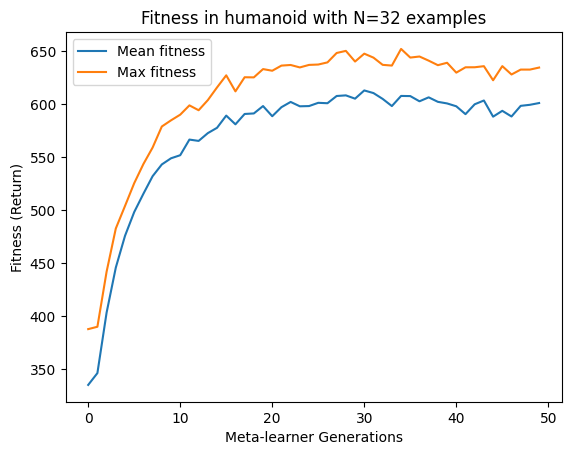

In [30]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in {config['ENV_NAME']} with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

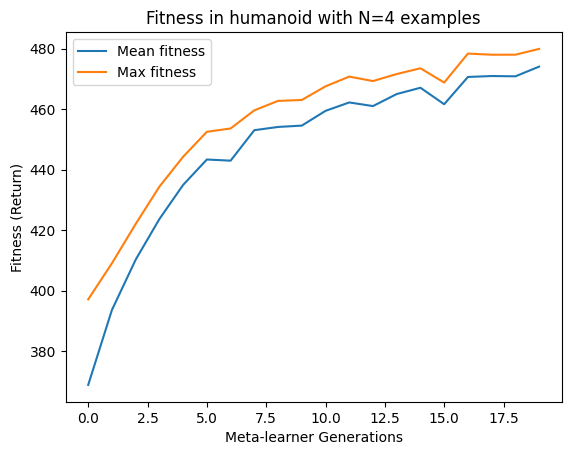

In [12]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in {config['ENV_NAME']} with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

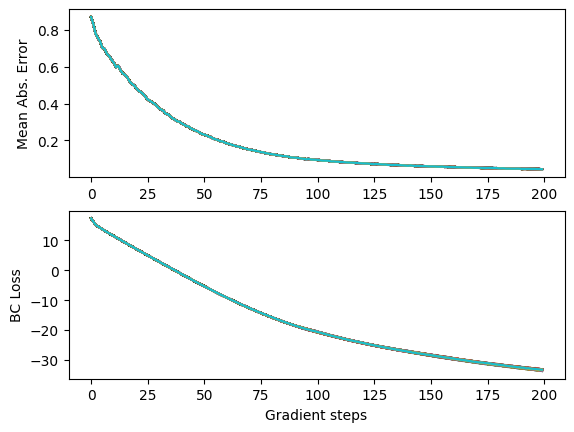

In [31]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Mean Abs. Error")

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

### Best candidate

In [ ]:
x = jnp.expand_dims(state.best_member, axis=0)
x.shape

x = jnp.zeros((2,*state.best_member.shape))
x = x.at[0].set(state.best_member)

y = param_reshaper.reshape(x)
print(y["actions"][0])
print(y["states"][0])

### Best of last gen

In [ ]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))
    
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1]]
else:
    f = lambda x : x[best_idx]
final_dataset = jax.tree_util.tree_map(f, final_datasets_reshaped)

print("Final dataset:")
print(final_dataset)

In [ ]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
if len(jax.devices()) > 1:
    f = lambda x : x[best_idx[0], best_idx[1], 0]
else:
    f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret * best_dones).sum(axis=(-1, -2)) /best_dones.sum(axis=(-1, -2))
print("Best mean return per rollout", best_mean_ret)

In [ ]:
env = envs.get_environment(env_name='hopper', backend='positional')


In [ ]:
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

rng = jax.random.PRNGKey(42)
rng, reset_rng = jax.random.split(rng)
obs, env_state = env.reset(reset_rng, env_params)

rewards_per_ep = []

for t in tqdm(range(512)):
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    pi = train_state.apply_fn(best_params, obs)
    action = pi.argmax(axis=-1)
    
    obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
    rewards_per_ep.append(reward)
    if done:
        ep_ret = jnp.array(rewards_per_ep).sum()
        print("Ep return: ", ep_ret)
        rewards_per_ep = []


In [ ]:
import policy_distillation.render as pdr
import importlib
importlib.reload(pdr)

In [ ]:
from policy_distillation.render import render_pendulum as render_fn

D_size = es_config["dataset_size"]

fig, ax = plt.subplots(1, D_size, figsize=(12,8))

for i, x in enumerate(zip(final_dataset["states"], final_dataset["actions"])):
    synth_state, act = x
    img = render_fn(synth_state, act.item(), env_params)
    ax[i].imshow(img, label="hello")
    ax[i].set_title(f"action = {act.item():.2f}")
    
    v = synth_state[-1].item()
    
    
    print(synth_state)
    
#     ax[i].set_xticks([0, 600/2, 600], [-4.8, 0, 4.8])
    ax[i].text(30, 70, f"dθ={v:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [ ]:
width_list = [2,4,8,16,32,64,128,256,512,1024]
fit_list = {
            "relu" : [],
            "tanh" : []
           }
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = config["UPDATE_EPOCHS"]
    num_envs = 20
    
    fitness ={
            "relu" : -1,
            "tanh" : -1
           }
    
    for activation in ["relu", "tanh"]:
        new_config["ACTIVATION"] = activation

#         final_dataset # Given
#         action_labels # Given

        new_train_fn = make_train(new_config)

        def new_BC_train(rng_input, dataset, action_labels):
            out = new_train_fn(dataset, action_labels, rng_input)
            return out  # ["metrics"]['returned_episode_returns'].mean()

        vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None, None)))

        rng, rng_new = jax.random.split(rng)
        rng_batch = jax.random.split(rng_new, num_envs)

        out_new = vmapped_BC_train(rng_batch, final_dataset["states"], final_dataset["actions"])

        returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
        dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        fitness[activation] = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)

        bc_loss = out_new['metrics']['bc_loss'][:,-1]

        fit_list[activation].append(fitness[activation])
    
    print(f"Width {width} : fitness (relu)={fitness['relu'].mean():.1f} +/- {fitness['relu'].std():.1f}, "
         + f"fitness (tanh)={fitness['tanh'].mean():.1f} +/- {fitness['tanh'].std():.1f}")
    

In [ ]:
for activation, act_fit_list in fit_list.items():
    plt.scatter(width_list, [x.mean() for x in act_fit_list], label=activation)

    means = jnp.array([x.mean() for x in act_fit_list])
    stds = jnp.array([x.std() for x in act_fit_list])

    plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)
plt.title(f"Dataset transfer (original: {config['ACTIVATION']}{config['WIDTH']} )")
plt.legend()
plt.show()